In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import difflib
%config InlineBackend.figure_format = 'retina'
from matplotlib import cm
import glob
from tifffile import imread, imwrite
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.models import Config, CARE
import skimage
from skimage import transform
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects
from pathlib import Path
from skimage.filters import sobel
from skimage.util import invert
from skimage.measure import label
from PIL import Image

Using TensorFlow backend.


In [2]:
Masterdir = '/media/sancere/Newton_Volume_1/DalmiroAnalysis/R/'
Savedir = '/media/sancere/Newton_Volume_1/DalmiroAnalysis/UnRotated/'
Model_Dir = '/home/sancere/Kepler/CurieDeepLearningModels/'
UNETSegmentationModelName = 'DeepWingSegmentationModelUNET'
UnetModel = CARE(config = None, name = UNETSegmentationModelName, basedir = Model_Dir)
Path(Savedir).mkdir(exist_ok = True)






Loading network weights from 'weights_best.h5'.








In [3]:
def doubleplot(imageA, imageB, titleA, titleB, targetdir = None, File = None, plotTitle = None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ax = axes.ravel()
    ax[0].imshow(imageA, cmap=cm.gray)
    ax[0].set_title(titleA)
    ax[0].set_axis_off()
    ax[1].imshow(imageB, cmap=plt.cm.nipy_spectral)
    ax[1].set_title(titleB)
    ax[1].set_axis_off()

    plt.tight_layout()
    plt.show()
    for a in ax:
      a.set_axis_off() 

/home/sancere/anaconda3/lib/python3.7/site-packages/csbdeep/models/base_model.py:255: UserWarning: skipping normalization step after prediction because number of input and output channels differ.
  warnings.warn('skipping normalization step after prediction because ' +


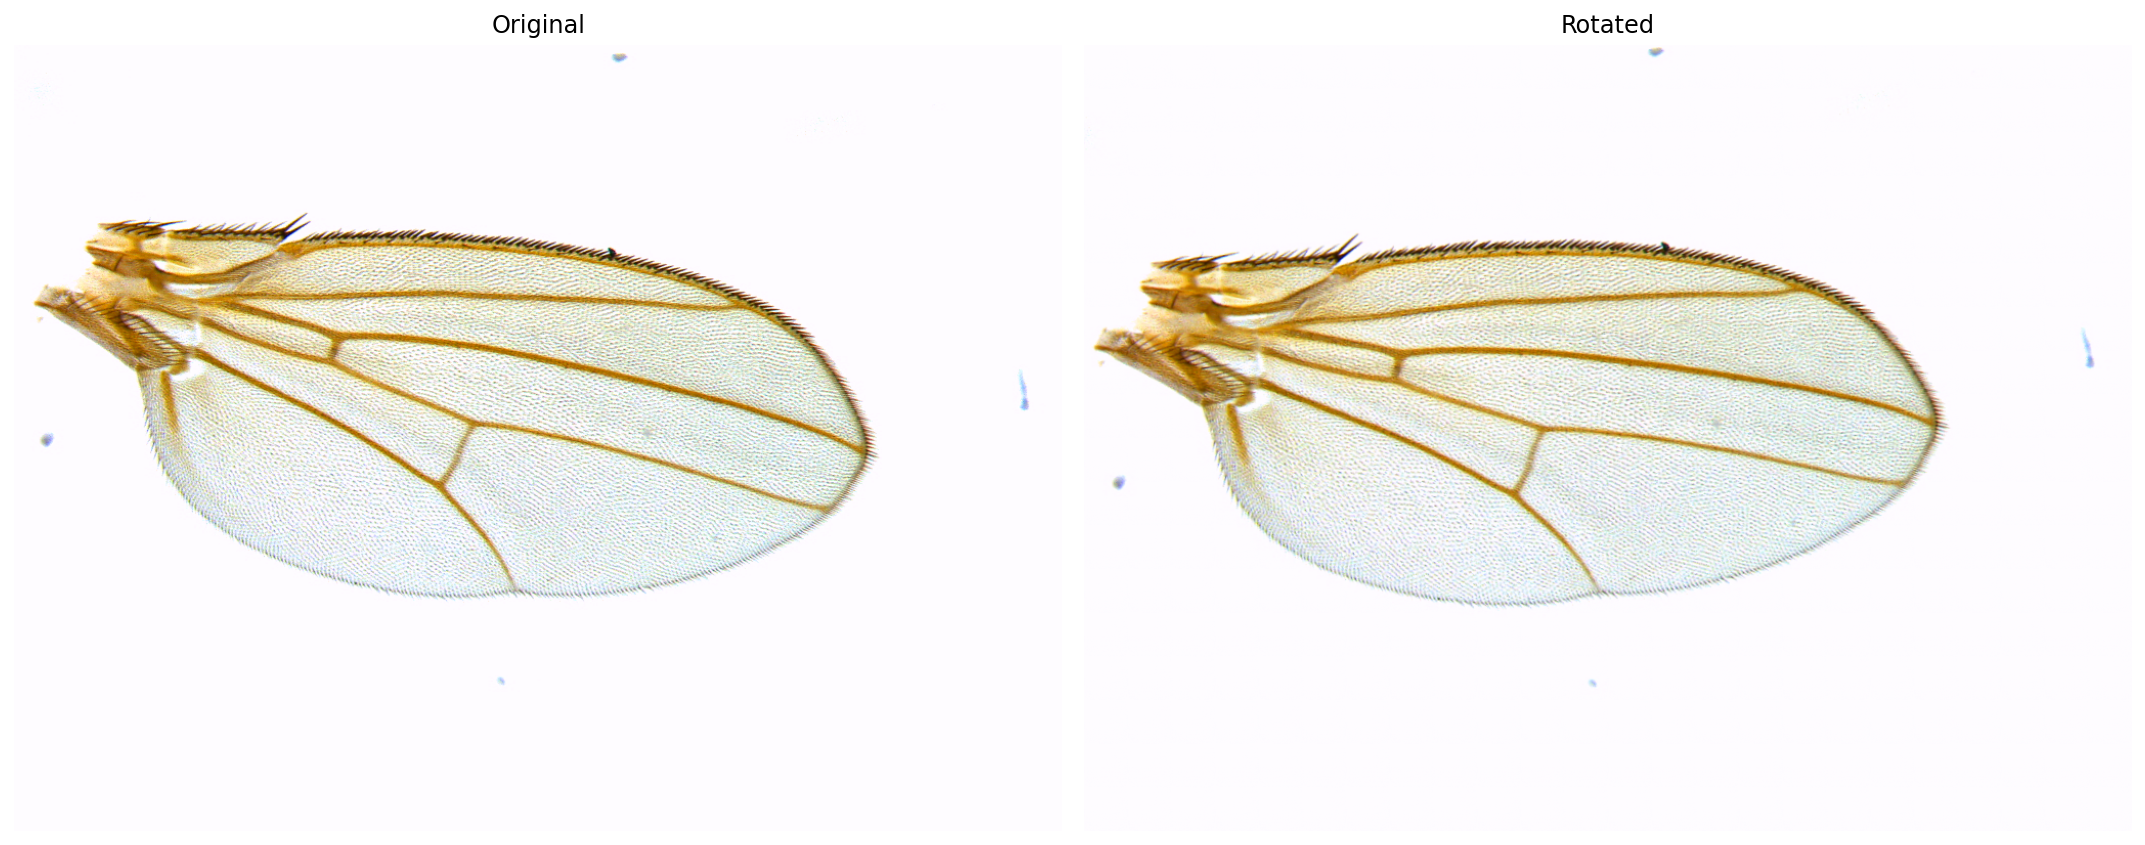

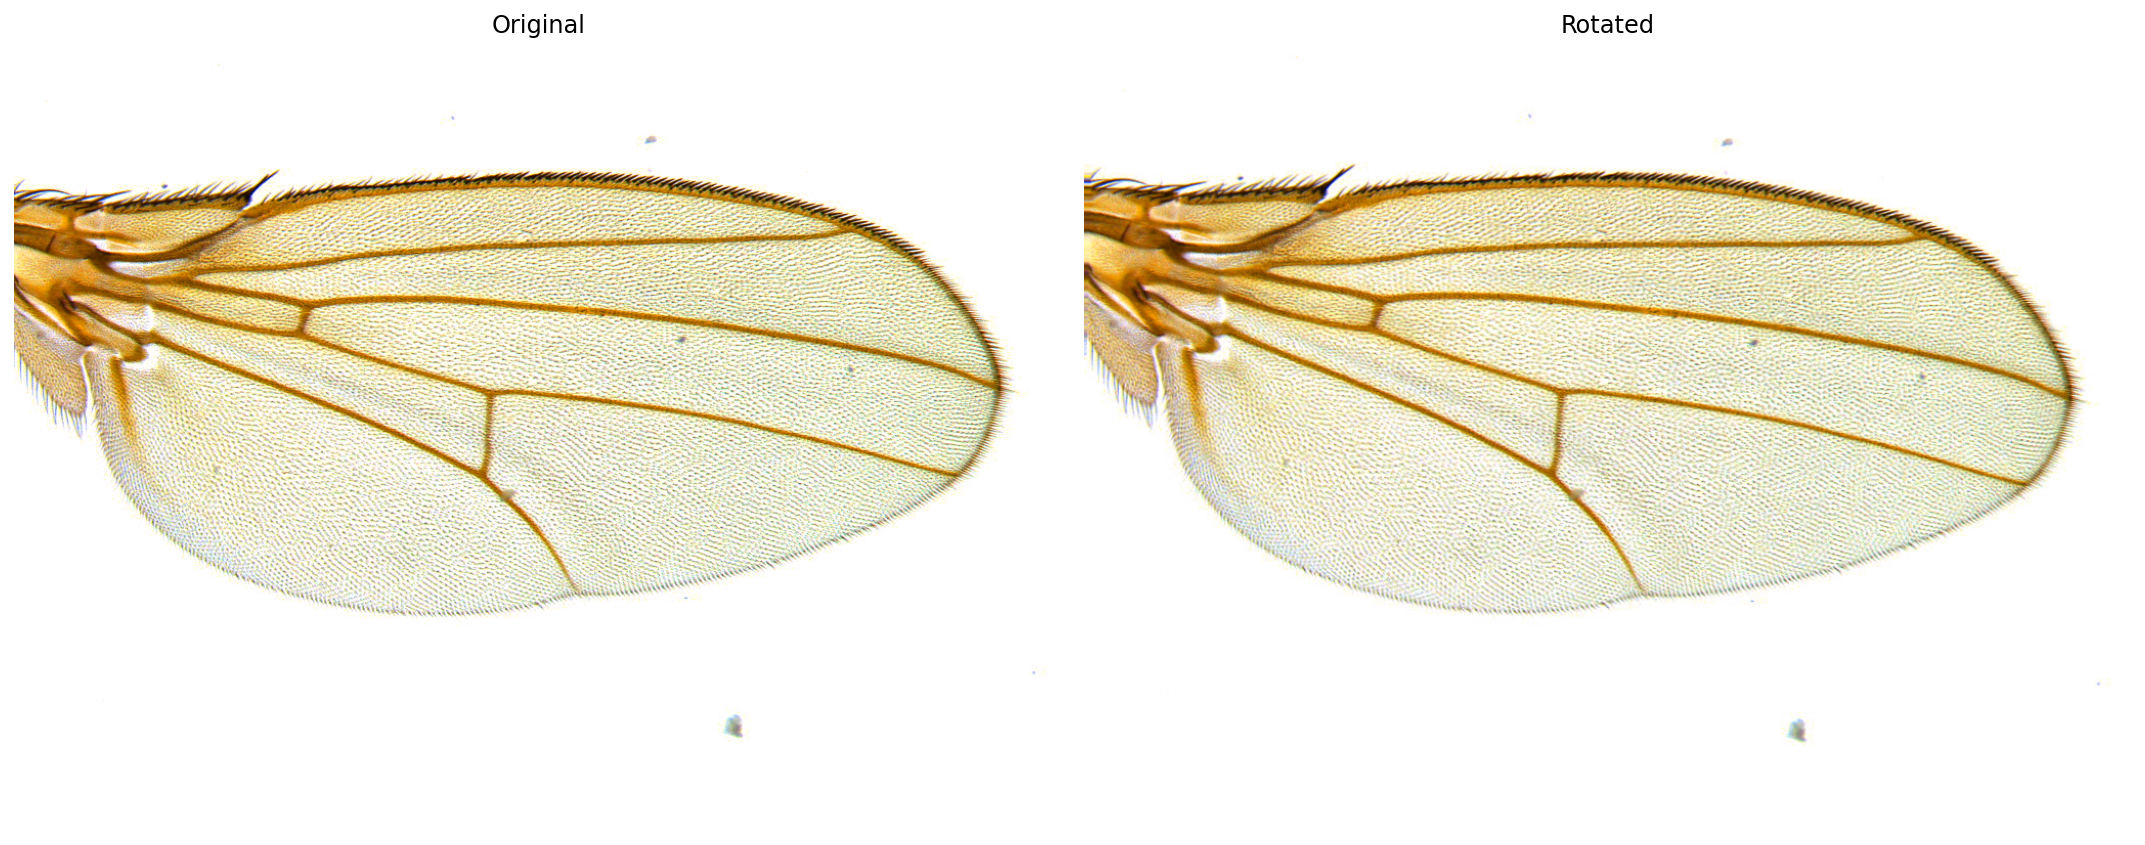

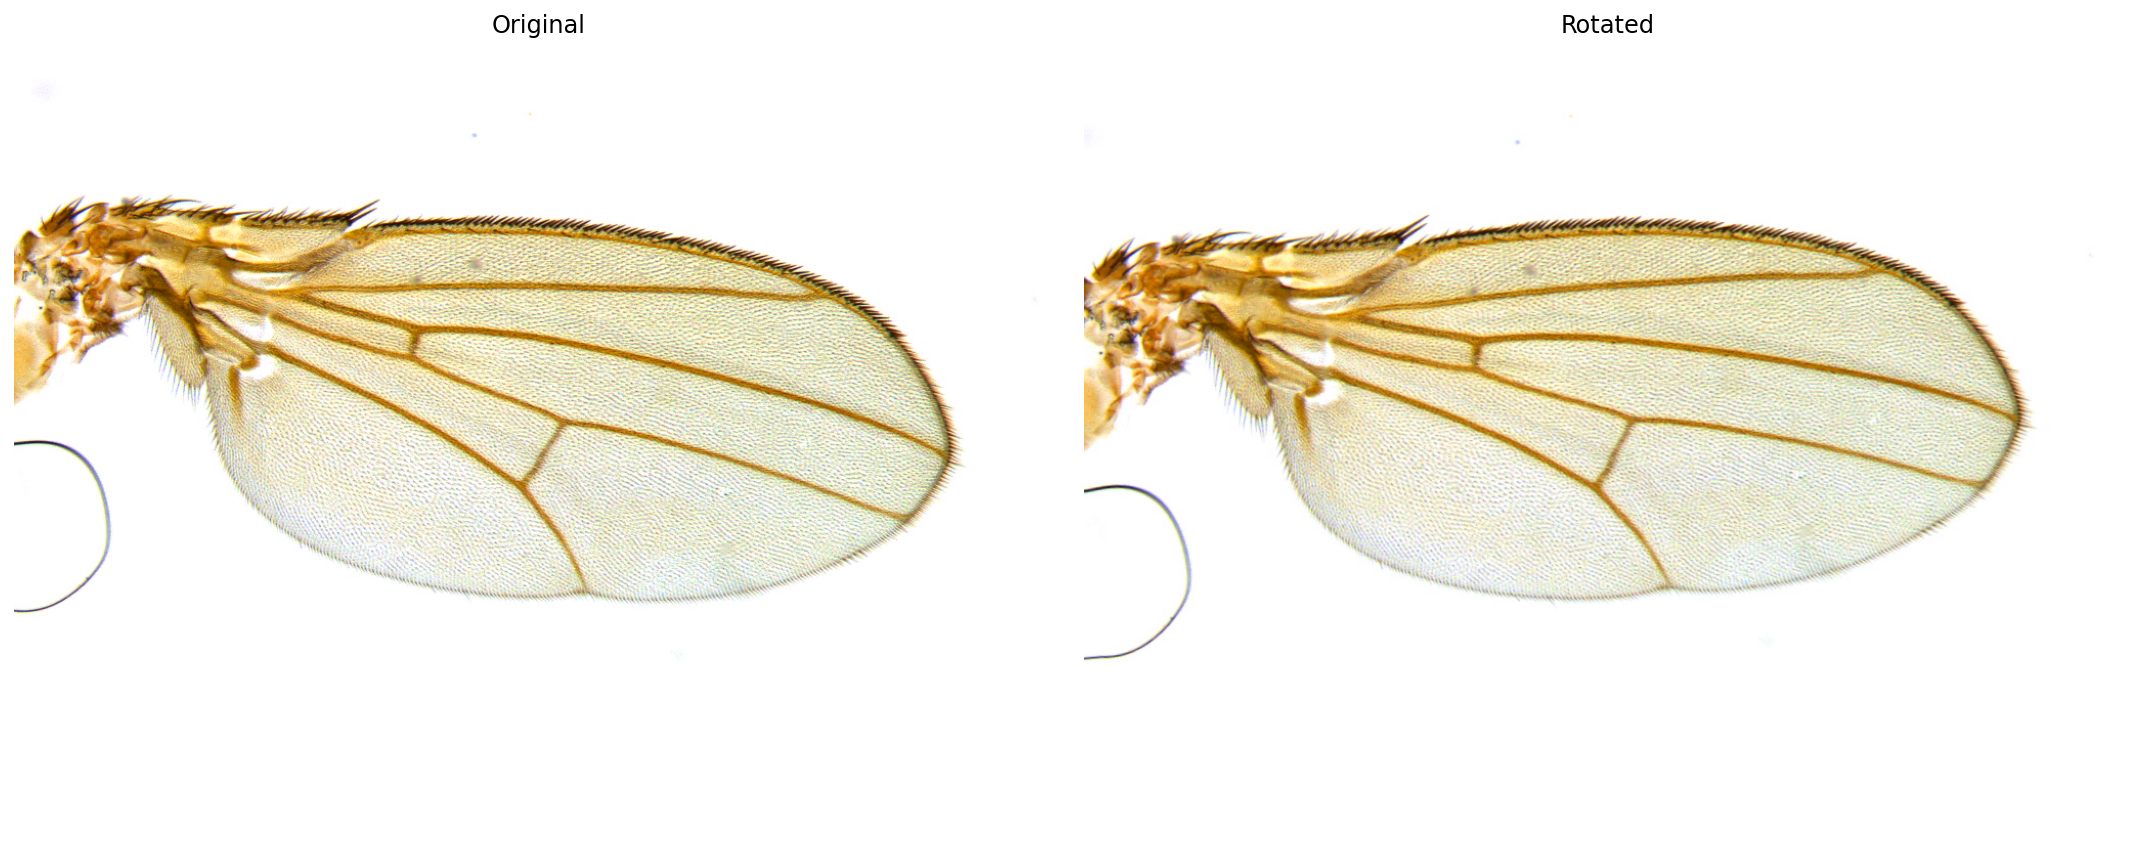

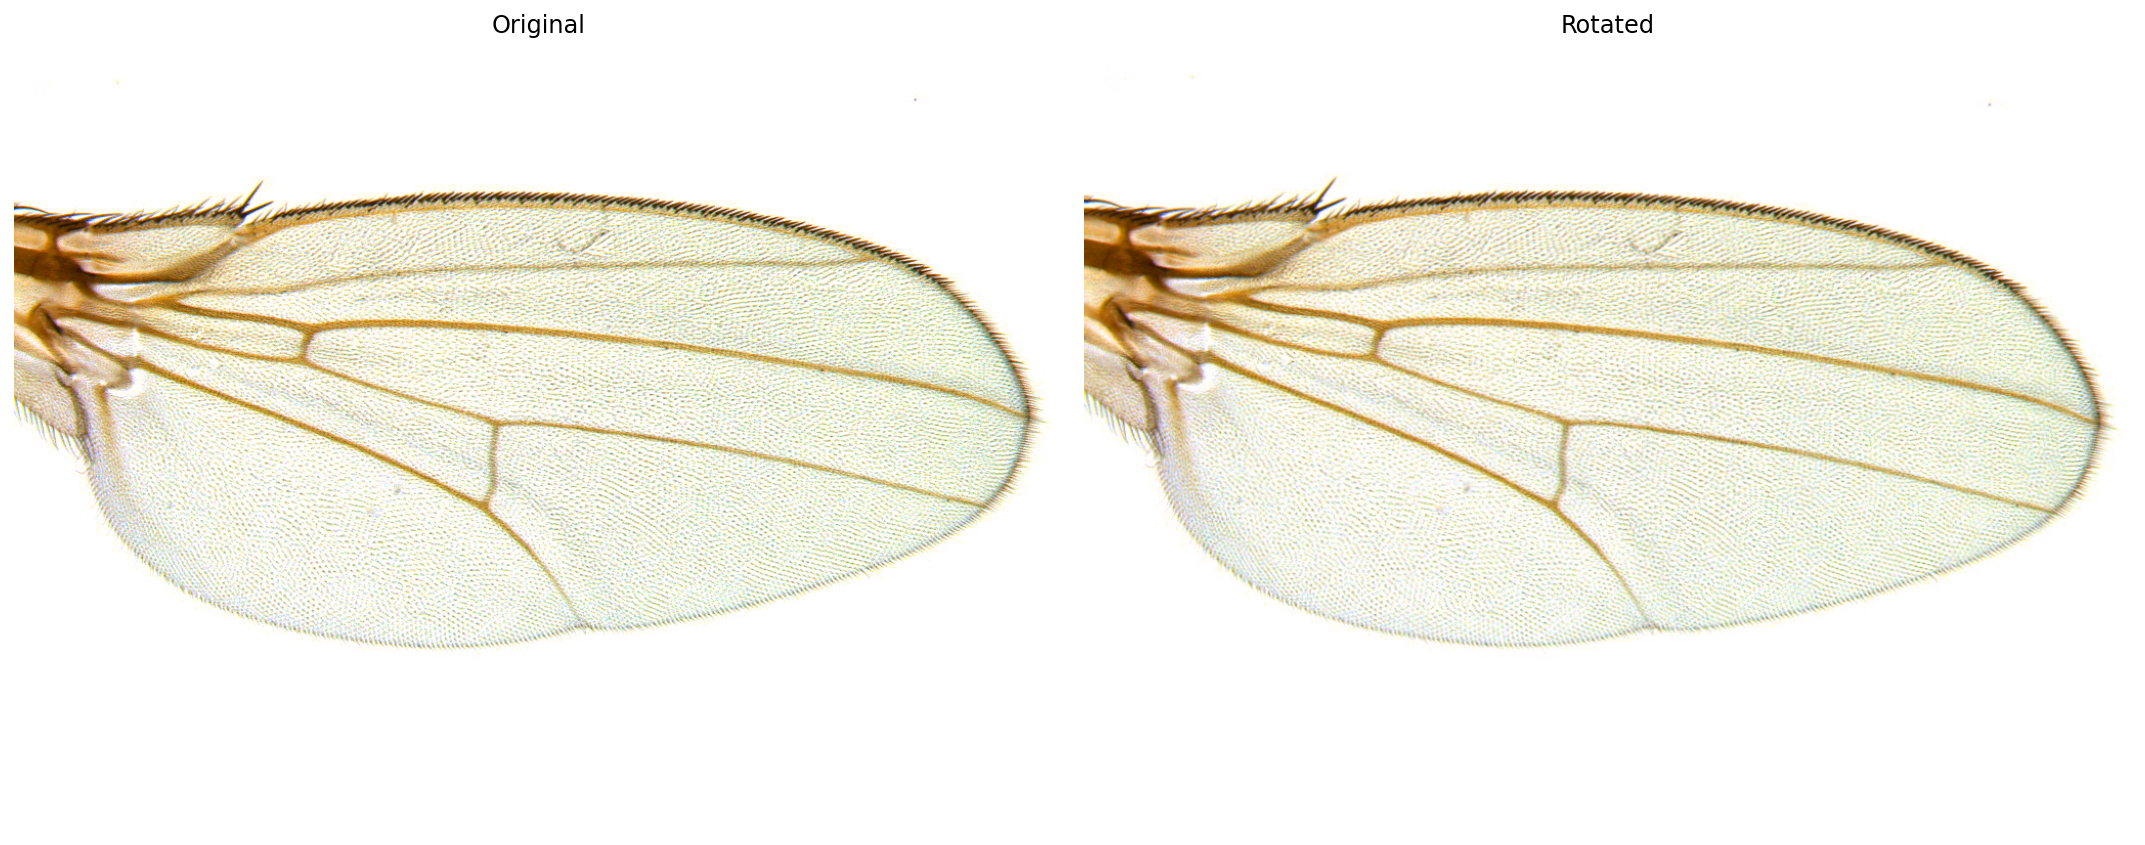

In [4]:
Raw_path = os.path.join(Masterdir, '*tiff')
filesRaw = glob.glob(Raw_path)
filesRaw.sort
axes = 'YXC'
count = 0
min_size = 15000
for fname in filesRaw:
            
            #Read image        
            image = imread(fname)
            
            
            Name = os.path.basename(os.path.splitext(fname)[0])
            
            image = image[:,:,0:3]
            #DO the segmentation
            Segmented = UnetModel.predict(image,axes)
            thresh = threshold_otsu(Segmented) 
            Binary = Segmented > thresh
            Filled = binary_fill_holes(Binary)
            Finalimage = remove_small_objects(Filled, min_size)
            Finalimage = Finalimage[:,:,0]
            y, x = np.nonzero(Finalimage)
            x = x - np.mean(x)
            y = y - np.mean(y)
            coords = np.vstack([x, y])

            cov = np.cov(coords)
            evals, evecs = np.linalg.eig(cov) 


            sort_indices = np.argsort(evals)[::-1]
            x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
            x_v2, y_v2 = evecs[:, sort_indices[1]]

            #Uncomment lines below to see the eigenvectors
            #scale = 20
            #plt.plot([x_v1*-scale*2, x_v1*scale*2],
                    #[y_v1*-scale*2, y_v1*scale*2], color='red')
            #plt.plot([x_v2*-scale, x_v2*scale],
                    #[y_v2*-scale, y_v2*scale], color='blue')
            
            #plt.axis('equal')
            #plt.gca().invert_yaxis()  # Match the image system with origin at top left
            #plt.show()
            theta1 = np.arctan((x_v1)/(y_v1)) 
            theta2 = np.arctan((x_v2)/(y_v2)) 
            theta2deg = theta2 * 180 / 3.14
            theta1deg = theta1 * 180/3.14
            
           
            rotation_mat = np.matrix([[np.cos(theta2), -np.sin(theta2)],
                      [np.sin(theta2), np.cos(theta2)]])
            rotatedimage = transform.rotate(image,-theta2deg, resize = False, mode = "edge" )
            
            
            #Trial 2
            #DO bad segmentation
        
            testimage = rotatedimage[:,:,0] 
            thresh = threshold_otsu(testimage) 
            testimage = testimage > thresh
            testimage = invert(testimage)
            testimage = label(testimage)
            
            testimage = remove_small_objects(testimage)
            testimage = testimage > 0
          
           
            
            ySec, xSec = np.nonzero(testimage)
            xSec = xSec - np.mean(xSec)
            ySec = ySec - np.mean(ySec)
            coordsSec = np.vstack([xSec, ySec])

            covSec = np.cov(coordsSec)
            evalsSec, evecsSec = np.linalg.eig(covSec) 


            sort_indicesSec = np.argsort(evalsSec)[::-1]
            x_v1Sec, y_v1Sec = evecsSec[:, sort_indicesSec[0]]  # Eigenvector with largest eigenvalue
            x_v2Sec, y_v2Sec = evecsSec[:, sort_indicesSec[1]]

          
            theta1Sec = np.arctan((x_v1Sec)/(y_v1Sec)) 
            theta2Sec = np.arctan((x_v2Sec)/(y_v2Sec)) 
            theta2degSec = theta2Sec * 180 / 3.14
            theta1degSec = theta1Sec * 180/3.14
            
       
            
            count = count + 1        
            if Name[-1] == 'R'and theta1degSec < 0:
                flippedimage = np.flip(rotatedimage, axis = 0)
                imwrite(Savedir + Name + '.tif', flippedimage)
                if count%100 == 0:
                   doubleplot(image, flippedimage, "Original", "Rotated-and-Flipped")

            if Name[-1] == 'R'and theta1degSec >= 0:   
                imwrite(Savedir + Name + '.tif', rotatedimage)
                if count%100 == 0:
                    doubleplot(image, rotatedimage, "Original", "Rotated")    

            if Name[-1] == 'L'and theta1degSec >= 0:
                flippedimage = np.flip(rotatedimage, axis = 0)
                imwrite(Savedir + Name + '.tif', flippedimage)
                if count%100 == 0:
                   doubleplot(image, flippedimage, "Original", "Rotated-and-Flipped")    

            if Name[-1] == 'L'and theta1degSec < 0:   
                imwrite(Savedir + Name + '.tif', rotatedimage)
                if count%100 == 0:
                    doubleplot(image, rotatedimage, "Original", "Rotated")